In [42]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import csv
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets

In [43]:
# Load the Pre-Trained ResNet Model
vgg_cnn = models.vgg19(weights=models.VGG19_Weights)
vgg_cnn.eval()

c:\Users\seanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
img_transform = transforms.Compose([
    # Convert the image into a tensor and perform normalization.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [46]:
class ReadDataCSV(Dataset):
    def __init__(self, csv_file_path, train=True, transform=None):
        data = pd.read_csv(csv_file_path)

        # Raw data extracted from csv file
        raw = data.to_numpy
        # Get the number of images in the CSV file
        num_images = data.shape[0]
        # All images stored as an array of pixels
        image_as_array = data.values[:,1:]
        # Labels from 1-18. One for each class. Each class represents a different family of fish.
        label_as_array = data.values[:,0]
        # Reshape the row of pixels into a 150x150x3 RGB image
        self.images_numpy = image_as_array.reshape(num_images, 150, 150, 3)
        self.targets = label_as_array
        self.transform = transform
    
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        # Get the specific image and label from the array
        img, target = self.images_numpy[index], self.targets[index]
        img = img.squeeze().astype(np.uint8)
        img = Image.fromarray(img)

        # Perform image transformation (normalization)
        if self.transform is not None:
            img = self.transform(img)
        # Convert the target label into a tensor
        target = torch.tensor(target)
        return img, target

In [47]:
dataset = ReadDataCSV("test_data.csv",transform=img_transform)
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


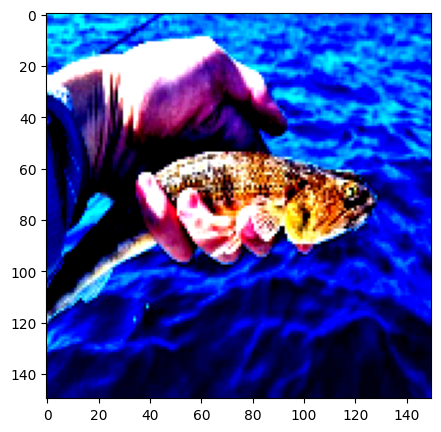

In [48]:
# Display an image from the training dataset to show that we are getting what we expect
[imgs,labels] = (next(iter(dataloader)))
imgs = np.squeeze(imgs)
plt.figure(figsize=(5,5))
plt.imshow(imgs[0].permute(1,2,0).cpu().numpy())

In [49]:
train_dataset = ReadDataCSV("train_data.csv",transform=img_transform)
test_dataset = ReadDataCSV("test_data.csv",transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [51]:
#VGG Model
model = models.vgg16(pretrained=True)

# Define the VGG-19 model
num_features = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_features, 290)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.009, momentum=0.9)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the VGG-19 CNN using our test database
for epoch in range(25): # loop over the dataset multiple times. Here 25 means 25 epochs
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    print(f"Epoch [{epoch+1}/{20}], Loss: {running_loss / len(train_dataloader.dataset)}")

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0

    # Test the VGG-19 CNN model on our training database
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy on test set after epoch {epoch+1}: {(100 * correct / total):.2f}%")

print('Finished Training')
torch.cuda.empty_cache()    